# Example : Using the magnetic probes

This example will show how to use the probes class.

## Generate a starting equilibrum (via a forward solve)

First, we need a tokamak and equilibrium since the probes take properties from the equilibrium as inputs. 

We will copy the code from example_1 to generate a sample equilibrium.

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:516: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-09 with less than 20 iterations. Last relative psi change: 3.152160257345964e-08.
  warnings.warn(


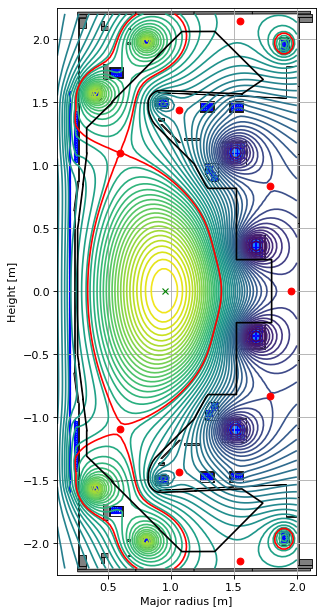

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt


# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_like_magnetic_probes.pickle"   # new probe path

# build the machine
from freegsnke import build_machine
tokamak = build_machine.tokamak()

# initialise the equilibrium
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

# load the nonlinear solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set the coil currents
import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

# carry out the foward solve to find the equilibrium
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# updates the plasma_psi (for later on)
eq._updatePlasmaPsi(eq.plasma_psi)

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Using the probe objects

The tokamak object has a probe object attribute pre-initialised, however, if we wanted to we could create a stand alone one by importing `freegsnke.magnetic_probes` and then setting up with `probes = magnetic_probes.Probe()`. 

In the tokamak, the probes object is located in `tokamak.probes`. When initialised it reads the information on the names, positions and orientations of the different probes from the pickle file. 

We need to initialise the Greens functions that are used in the calculations. This is done by running `tokamak.probes.initialise_setup(eq)`. This takes an input equilibrium object and saves probe attributes for each current source (i.e. the coils and the plasma) and evaluates the Greens functions at the positions of the probes. The purpose of the equilibrium here is to provide the size/shape of the grid that is used when determining the plasma Greens functions. 

In [2]:
tokamak.probes.initialise_setup(eq)

Once initialised we can also now access information from the different probes:
- **flux loops**  measure $\psi(r,z)$.
- **pickup coils** measure $\vec B(r,z)\cdot \hat n$ where $\hat n$ is the orientation vector of the pickup coil.

In [3]:
# display the first five flux loop info
tokamak.probes.floops[0:5]
#print(tokamak.probes.floop_order[:5])
#print(tokamak.probes.floop_pos[:5])

[{'name': 'f_nu_01', 'position': array([0.901 , 1.3582], dtype=float32)},
 {'name': 'f_nu_02', 'position': array([0.9544   , 1.3041999], dtype=float32)},
 {'name': 'f_nu_03', 'position': array([1.0445   , 1.2150999], dtype=float32)},
 {'name': 'f_nu_04', 'position': array([1.1239, 1.1366], dtype=float32)},
 {'name': 'f_nu_a05', 'position': array([1.1505, 1.1987], dtype=float32)}]

In [4]:
# display the first five pickup coils info
tokamak.probes.pickups[0:5]
#print(tokamak.probes.floop_order[:5])
#print(tokamak.probes.floop_pos[:5])

[{'name': 'b_c1_p01',
  'position': array([2.76900e-01, 3.00000e+02, 1.26203e+00], dtype=float32),
  'orientation': 'PARALLEL',
  'orientation_vector': array([0., 0., 1.], dtype=float32)},
 {'name': 'b_c1_t02',
  'position': array([2.7689108e-01, 2.9999680e+02, 1.2245095e+00], dtype=float32),
  'orientation': 'TOROIDAL',
  'orientation_vector': array([0., 1., 0.], dtype=float32)},
 {'name': 'b_c1_p03',
  'position': array([2.7689999e-01, 3.0000000e+02, 1.1870301e+00], dtype=float32),
  'orientation': 'PARALLEL',
  'orientation_vector': array([0., 0., 1.], dtype=float32)},
 {'name': 'b_c1_t04',
  'position': array([2.7689108e-01, 2.9999680e+02, 1.1495094e+00], dtype=float32),
  'orientation': 'TOROIDAL',
  'orientation_vector': array([0., 1., 0.], dtype=float32)},
 {'name': 'b_c1_p05',
  'position': array([2.76900e-01, 3.00000e+02, 1.11203e+00], dtype=float32),
  'orientation': 'PARALLEL',
  'orientation_vector': array([0., 0., 1.], dtype=float32)}]

Now in principle we could update and re-solve for the equilibrium. Doing this will not require any changes to the probe object, assuming the machine setup doesn't change. 

Once we have the equilibrium we want to analyse with the probes, we can call the probe functions `calculate_fluxloop_value(eq)` and `calculate_pickup_value(eq)`, the outputs of which are arrays with probe values for each probe. 

If one is interested in certain probes, then `tokamak.probes.floop_order` and `tokamak.probes.pickup_order` contain a list of the probe names which can be used to find the appropriate element of the output list. Alternatively the could be combined into a dictionary.

In [5]:
# compute probe values from equilibrium 
floops_vals = tokamak.probes.calculate_fluxloop_value(eq)
pickups_vals = tokamak.probes.calculate_pickup_value(eq)

In [6]:
# create dictionary to access specific values (show here for the flux loops)
dict = {}
for i, el in enumerate(tokamak.probes.floop_order):
    dict[el] = floops_vals[i]
dict

{'f_nu_01': 0.013301261943134794,
 'f_nu_02': 0.012736524978301411,
 'f_nu_03': 0.010552133422114956,
 'f_nu_04': 0.006763157931533641,
 'f_nu_a05': 0.00335317921898607,
 'f_nu_b05': 0.0029372862104298098,
 'f_nu_06': 0.0008107912083261531,
 'f_nl_01': 0.012912983004685137,
 'f_nl_02': 0.012401644537335636,
 'f_nl_03': 0.010262163684476137,
 'f_nl_04': 0.0064843935450968615,
 'f_nl_a05': 0.003169500298538533,
 'f_nl_b05': 0.0027602214021628865,
 'f_nl_06': 0.000666191231481747,
 'f_p6u_01': 0.0006644077356911526,
 'f_p6l_01': -0.00010135689416135296,
 'f_bu_01': 0.010989075703044821,
 'f_bu_02': 0.008693199973507475,
 'f_bu_03': 0.0020514905331524246,
 'f_bu_04': -0.004165558466501844,
 'f_bl_01': 0.011210029284265136,
 'f_bl_02': 0.008810809936181472,
 'f_bl_03': 0.002230559768216518,
 'f_bl_04': -0.0038053567760713836,
 'f_p5u_01': -0.028863945090427584,
 'f_p5u_02': -0.03333536569316892,
 'f_p5u_03': -0.03166512160633472,
 'f_p5u_04': -0.023898006056131238,
 'f_p5l_04': -0.025640114

Suppose we want to compute a new equilibrium with a different grid spacing or shape. We don't need to update the probe objects, we simply pass the new equilibrium to the 'calculate' functions. The first time a new grid is encountered it will create a new set of greens functions and save them to a dictionary so that they can be reused in the future if the same grid is used again. 

Below is a new equilibrium with a modified grid shape and spacing. When a new grid is encountered, a message is displayed to tell that new greens are computed. Note it only does it the first time.

Note that computing on a different grid but with same plasma setup should give the same values at the probes (which it does). 

In [7]:
# initialise the equilibrium
eq_new = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.0, Zmax=2.0,  # Vertical range
    nx=65,                # Number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # Number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  


from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq_new,
    limiter=tokamak.limiter,
    paxis=8e3,
    Ip=6e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq_new)    

import pickle
with open('simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)
for key in current_values.keys():
    eq_new.tokamak[key].current = current_values[key]

GSStaticSolver.solve(eq=eq_new, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

/Users/zn8047/Documents/freegsnke/freegsnke/GSstaticsolver.py:516: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-09 with less than 20 iterations. Last relative psi change: 6.136758911498162e-09.
  warnings.warn(


In [8]:
floops_vals_new = tokamak.probes.calculate_fluxloop_value(eq_new)
pickups_vals_new = tokamak.probes.calculate_pickup_value(eq_new)

new equilibrium grid - computed new greens functions
new equilibrium grid - computed new greens functions


In [9]:
# compare values
print(floops_vals[:5])
print(floops_vals_new[:5])

[0.01330126 0.01273652 0.01055213 0.00676316 0.00335318]
[0.01330039 0.01273547 0.01055068 0.00676126 0.00335141]


In [10]:
# compare values
print(pickups_vals[:5])
print(pickups_vals_new[:5])

[0.07659762 1.8057642  0.04330629 1.8057642  0.02750124]
[0.07659646 1.8057642  0.04330547 1.8057642  0.02750096]


If we re-run this same line of code, we don't get the message that the greens functions have been recalculated. They are stored in a dictionary labeled by a key containing the grid specification in the form `key = (Rmin,Rmax,Zmin,Zmax,nx,ny)`.

In [11]:
pickup_vals_new2 = tokamak.probes.calculate_pickup_value(eq_new)

# show greens function keys
tokamak.probes.greens_B_plasma_oriented.keys()


dict_keys([(0.1, 2.0, -2.2, 2.2, 65, 129), (0.1, 2.0, -2.0, 2.0, 65, 129)])

We can also plot the fluxloop and the pickup coil locations (and orientations) on our machine model. 

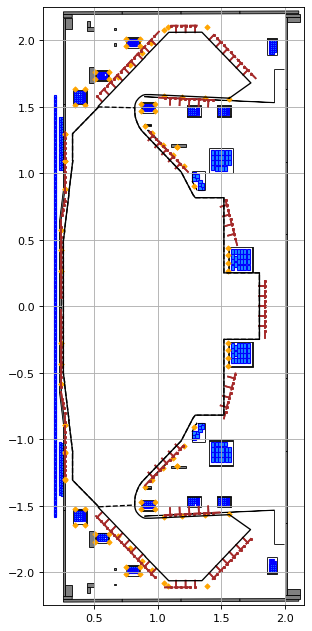

In [12]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
# eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
eq.tokamak.probes.plot(axis=ax1, show=False, floops=True, pickups=True, pickups_scale=0.05)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()